In [46]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26, read_datasets
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot, select_ACC, select_Equator
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted, CoarsenKochkovMinMax
from helpers.state_functions import *

import hvplot.xarray
import hvplot
import cmocean

import os
import json
from helpers.ann_tools import ANN
import pandas as pd

import matplotlib as mpl

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def read_skill_and_config(exp='EXP0', factors=[4,9,12,15]):
    skill = []
    for factor in factors:
        dataset = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        skill.append(dataset)
    skill = xr.concat(skill, dim='factor')
    skill['factor'] = factors

    with open(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/configuration.txt','r') as file:
        config = json.loads(file.read())

    return skill, config

In [6]:
def op_count(config):
    '''
    Compute the number of operations for ANN inference, which include:
    additions
    multiplications
    ifs (one ReLU is considered as one operation)
    We assume inputs of size 27 (3 gradients on stencil 3x3) 
    and output of size 3 (components of momentum flux)

    Additionally, we return the number of parameters
    '''
    hidden_layers = eval(config['hidden_layers'])
    layers = [27] + hidden_layers + [3]
    def layer_opcount(input_width, output_width, activation=True):
        '''
        Number of operations to go from one layer to another according to the loop in MOM_ANN.F90
          do j=1,layer%output_width
            y(j) = 0.
            do i=1,layer%input_width
              ! Multiply by kernel
              y(j) = y(j) + ( x(i) * layer%A(j, i) )
            enddo
            ! Add bias
            y(j) = y(j) + layer%b(j)
            ! Apply activation function
            if (layer%activation) then
              y(j) = activation_fn(y(j))
            endif
          enddo
        '''
        multiplications = input_width * output_width # matmul
        additions = input_width * output_width + output_width #matmul + bias
        if activation:
            ifs = output_width
        else:
            ifs = 0

        ops = multiplications + additions + ifs
        #print(input_width, output_width, activation, ops)
        return ops

    ops = 0
    for j in range(len(layers)-2):
        ops += layer_opcount(layers[j],layers[j+1],True)
    ops += layer_opcount(layers[-2],layers[-1],False)
    return ops, ANN(layers).count_parameters()

In [119]:
R2s = []
ops = []
labels = []
loggers = {}
for folder in os.listdir('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/Collocated-NN-params'):
    skill, config = read_skill_and_config(f'Collocated-NN-params/{folder}')
    R2 = float(skill.R2.mean())
    op, _ = op_count(config)
    label = config['hidden_layers']
    logger = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/Collocated-NN-params/{folder}/model/logger.nc')

    R2s.append(R2)
    ops.append(op)
    labels.append(label)
    loggers[label] = logger

In [120]:
idx = np.argsort(R2s)

In [121]:
R2s = np.array(R2s)[idx]
ops = np.array(ops)[idx]
labels = np.array(labels)[idx]

In [132]:
R2s

array([0.46074468, 0.48384666, 0.49786216, 0.50465643, 0.54878092,
       0.55120599, 0.55729544, 0.55806065, 0.55855662, 0.56031406,
       0.56964141, 0.57392973, 0.57565653, 0.58017951, 0.58370149,
       0.58417499, 0.58846647, 0.58971941, 0.5966813 , 0.599666  ,
       0.61055839, 0.61525202, 0.6167599 , 0.6219148 , 0.62350756,
       0.633977  , 0.63515866, 0.63761103, 0.64601326, 0.65851367,
       0.66517162])

In [123]:
labels

array(['[16,8,4]', '[8,8,8]', '[16]', '[20]', '[16,8]', '[32]',
       '[20,10,5]', '[16,16,16]', '[16,16]', '[20,10]', '[32,5]', '[48]',
       '[20,20]', '[32,8,4]', '[32,10]', '[20,20,20]', '[64]',
       '[32,10,5]', '[32,16,8]', '[32,32]', '[128]', '[32,32,32]',
       '[64,16]', '[128,8]', '[48,48]', '[64,64]', '[48,48,48]',
       '[128,16]', '[64,64,64]', '[128,128]', '[128,128,128]'],
      dtype='<U13')

In [124]:
ops

array([ 1267,   787,   995,  1243,  1219,  1987,  1683,  2083,  1539,
        1603,  2155,  2979,  2083,  2419,  2515,  2923,  3971,  2595,
        3171,  4099,  7939,  6211,  5763,  9283,  7683, 12291, 12387,
       11395, 20611, 40963, 73987])

In [125]:
R2_ops = pd.DataFrame({"R2": R2s, 
                       "op": ops})

<Axes: xlabel='op'>

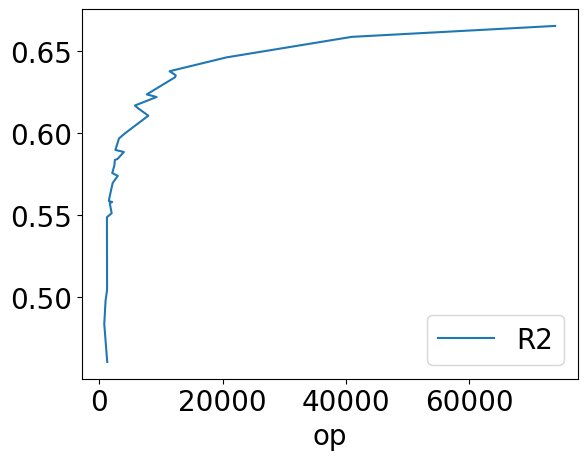

In [126]:
R2_ops.plot(x='op',y='R2')

In [127]:
from paretoset import paretoset
mask = paretoset(R2_ops, sense=["max", "min"])

In [128]:
mask

array([False,  True,  True, False,  True, False, False, False,  True,
        True, False, False,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True, False,  True, False, False,
        True,  True,  True,  True])

In [129]:
R2_ops[mask]

,R2,op
1,0.483847,787
2,0.497862,995
4,0.548781,1219
8,0.558557,1539
9,0.560314,1603
12,0.575657,2083
13,0.580180,2419
14,0.583701,2515
17,0.589719,2595
18,0.596681,3171


In [130]:
all_markers = ['o', 'v', '^', '<', '>',  '8', 's', 'p', '*', 'h', 'H', 'D', 'd','P', 'X']*4

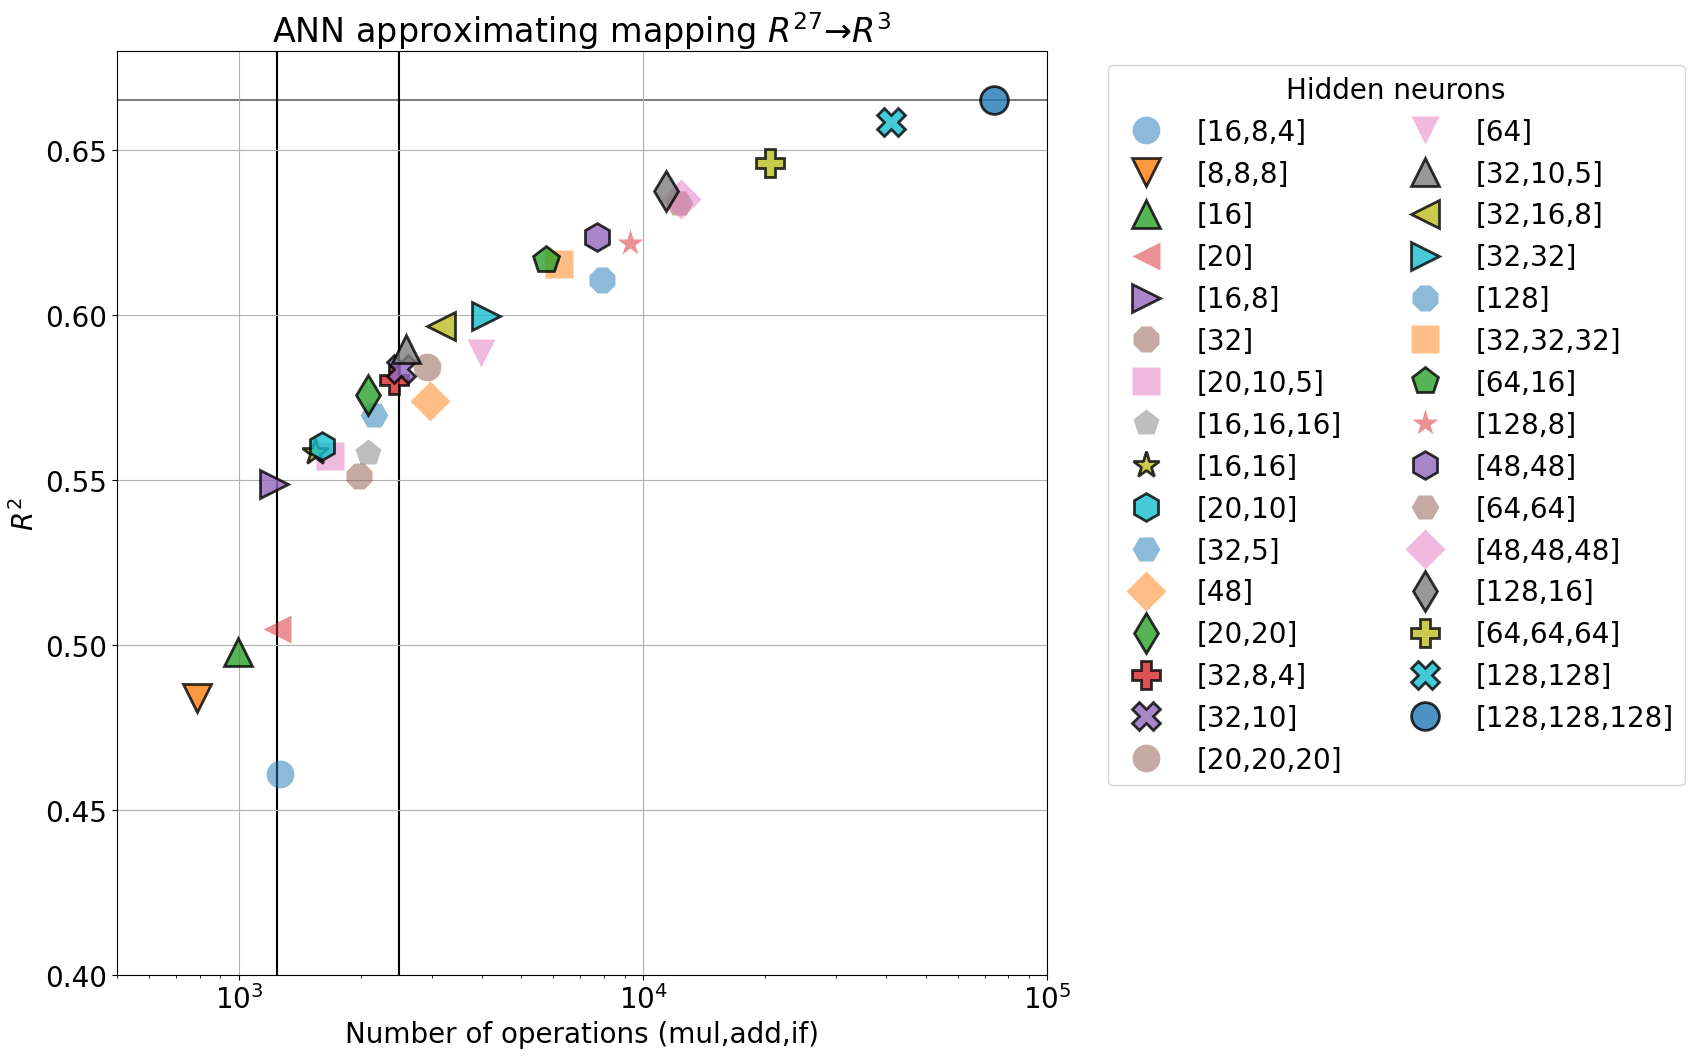

In [165]:
plt.figure(figsize=(12,12))
plt.rcParams['font.size'] = 20
for R2, op, pareto_optimal, label, marker in zip(R2s, ops, mask, labels, all_markers):
    plt.plot(op,R2,ls='',marker=marker,markersize=20,markeredgecolor='k' if pareto_optimal else 'None',alpha=0.8 if pareto_optimal else 0.5, label=label, markeredgewidth=2)
plt.axhline(y=R2.max(), color='gray', zorder=-1)
plt.legend(bbox_to_anchor=(1.05,1), title='Hidden neurons',ncols=2)
plt.ylabel('$R^2$',fontsize=20)
plt.xlabel('Number of operations (mul,add,if)', fontsize=20)
plt.xlim([500,100000])
plt.ylim([0.4,0.68])
plt.xscale('log')
plt.axvline(x=1243,color='k',zorder=-1)
plt.axvline(x=2*1243,color='k',zorder=-1)
plt.grid()
plt.title('ANN approximating mapping $R^{27}\\to R^3$')
plt.savefig('Numops.pdf', bbox_inches='tight')

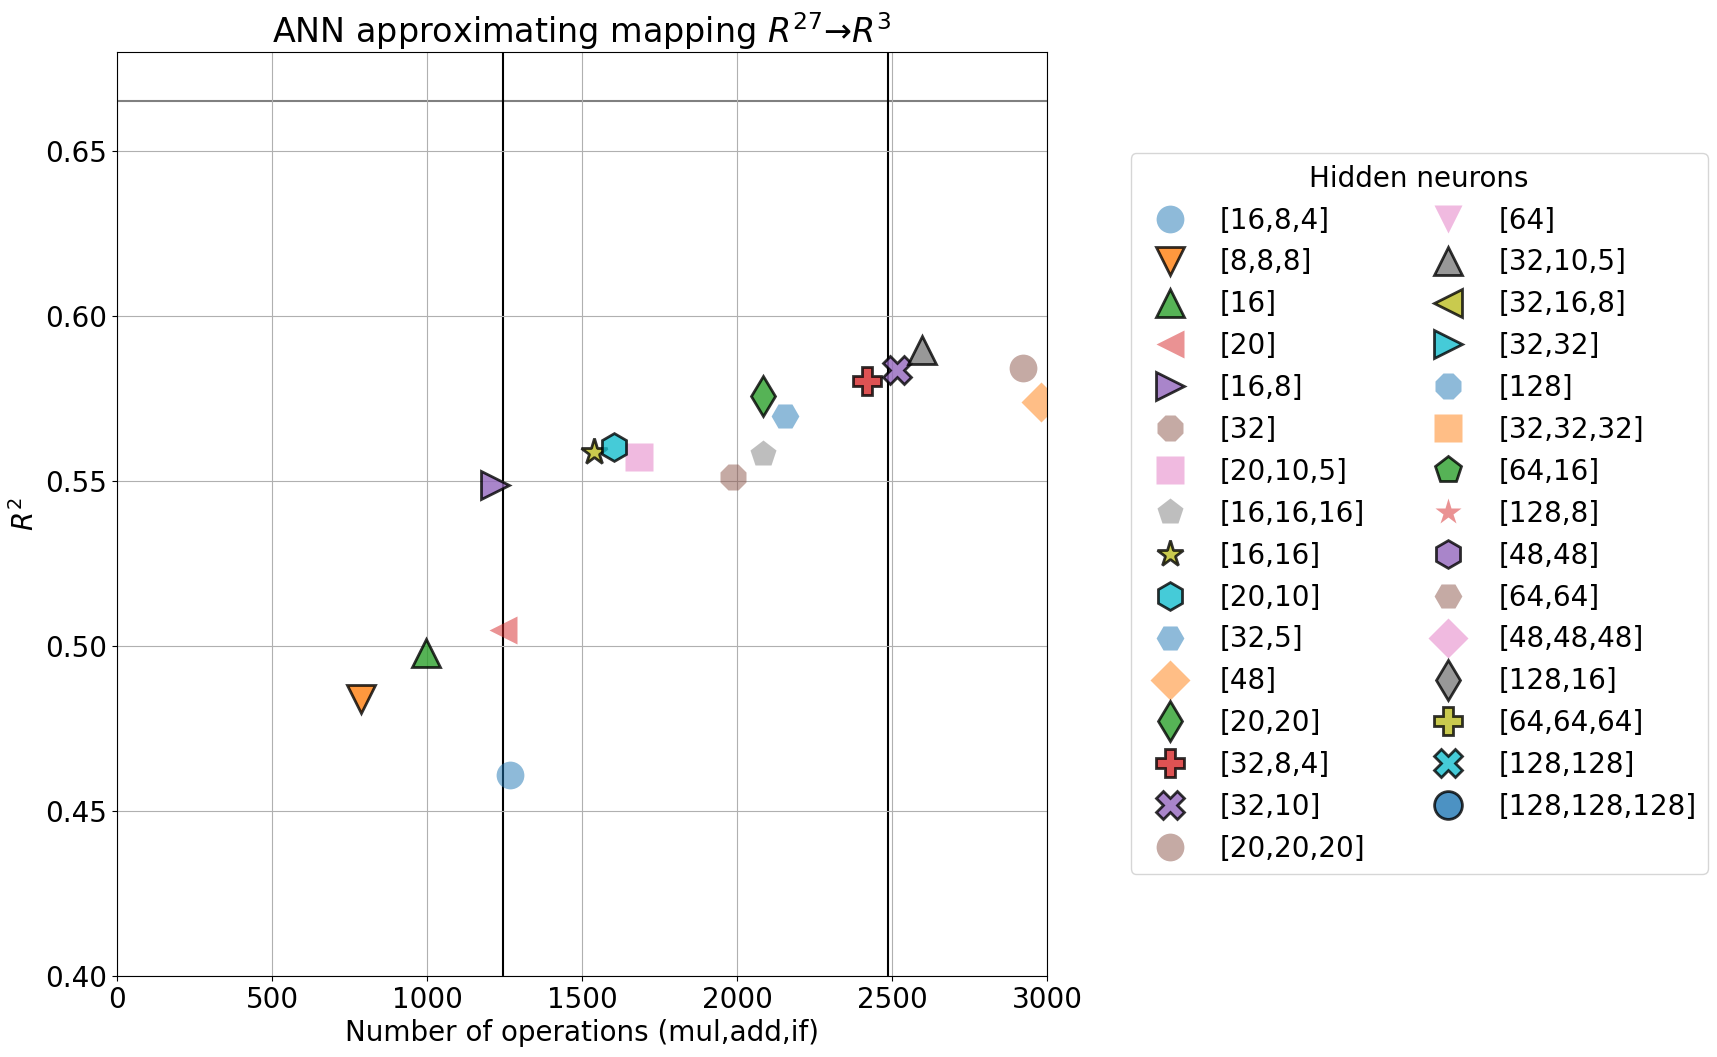

In [177]:
plt.figure(figsize=(12,12))
plt.rcParams['font.size'] = 20
for R2, op, pareto_optimal, label, marker in zip(R2s, ops, mask, labels, all_markers):
    plt.plot(op,R2,ls='',marker=marker,markersize=20,markeredgecolor='k' if pareto_optimal else 'None',alpha=0.8 if pareto_optimal else 0.5, label=label, markeredgewidth=2)
plt.axhline(y=R2.max(), color='gray', zorder=-1)
plt.legend(bbox_to_anchor=(1.4,0.5), title='Hidden neurons',ncols=2, loc='center')
plt.ylabel('$R^2$',fontsize=20)
plt.xlabel('Number of operations (mul,add,if)', fontsize=20)
plt.xlim([0,3000])
plt.ylim([0.4,0.68])
plt.axvline(x=1243,color='k',zorder=-1)
plt.axvline(x=2*1243,color='k',zorder=-1)
plt.grid()
plt.title('ANN approximating mapping $R^{27}\\to R^3$')
plt.savefig('Numops_linear.pdf', bbox_inches='tight')

(0.0, 1.0)

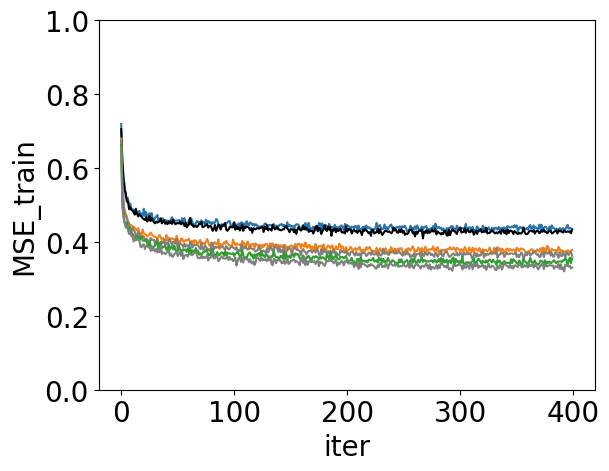

In [183]:
loggers['[20,20]'].mean(['depth','factor']).MSE_validate.plot()
loggers['[20,20]'].mean(['depth','factor']).MSE_train.plot(color='k')

loggers['[64,64]'].mean(['depth','factor']).MSE_validate.plot()
loggers['[64,64]'].mean(['depth','factor']).MSE_train.plot(color='gray')

loggers['[128,128,128]'].mean(['depth','factor']).MSE_validate.plot()
loggers['[128,128,128]'].mean(['depth','factor']).MSE_train.plot(color='gray')
plt.ylim([0,1])
plt.ylim([0,1])